✅ Mask detector loaded successfully.
✅ Quadrant-Fusion face model loaded successfully.


Testing Mask-Aware Faces: 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital


==== Mask-Aware Face Recognition Results ====
Accuracy: 78.95%
              precision    recall  f1-score   support

   alexandra      1.000     1.000     1.000         5
    courtney      0.600     1.000     0.750         3
   elizabeth      0.833     1.000     0.909         5
       henry      0.667     0.667     0.667         3
         zac      0.000     0.000     0.000         3

    accuracy                          0.789        19
   macro avg      0.620     0.733     0.665        19
weighted avg      0.682     0.789     0.726        19



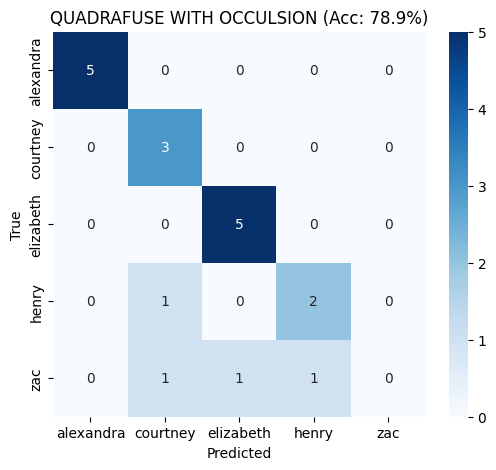

Analyzing Prediction Trend (Mask-Aware): 100%|██████████| 19/19 [00:07<00:00,  2.45it/s]


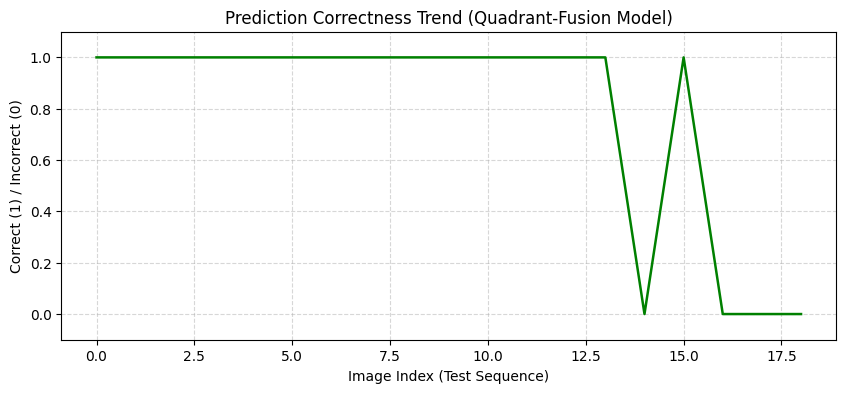

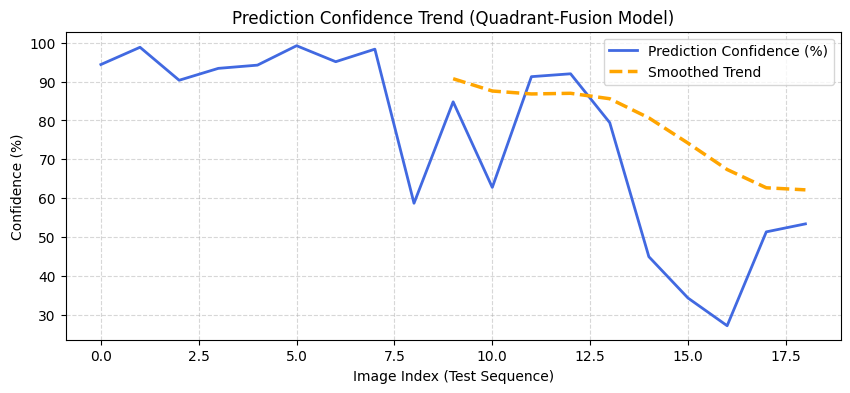

✅ Total Samples: 19
Average Confidence: 75.99%
Accuracy: 78.95%


In [2]:
# ============================================================
# 🧠 FACE RECOGNITION TESTING (MASK-AWARE)
# Uses: mask_detector_resnet18.pth + quadrant_fusion_faces.pth
# ============================================================

!pip install seaborn --quiet

import os, torch, cv2, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

# ---------------- CONFIG ----------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BASE_DIR = "/content/drive/MyDrive/FaceQuadrantNet"
MASK_DIR = f"{BASE_DIR}/Dataset_masked"
MASK_MODEL_PATH = f"{BASE_DIR}/mask_detector_resnet18.pth"
FACE_MODEL_PATH = f"{BASE_DIR}/quadrant_fusion_faces.pth"

TARGET_CLASSES = ["alexandra", "courtney", "elizabeth", "henry", "zac"]

val_tfms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# ---------------- MASK DETECTOR MODEL ----------------
mask_model = models.resnet18(weights=None)
mask_model.fc = nn.Linear(mask_model.fc.in_features, 2)
ckpt = torch.load(MASK_MODEL_PATH, map_location=DEVICE)
mask_model.load_state_dict(ckpt['model_state'], strict=False)
mask_model = mask_model.to(DEVICE)
mask_model.eval()
print("✅ Mask detector loaded successfully.")

mask_tfm = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

def detect_mask(image_path):
    """Return True if mask detected."""
    img = Image.open(image_path).convert("RGB")
    inp = mask_tfm(img).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = mask_model(inp)
        pred = torch.argmax(out, dim=1).item()
    return pred == 1  # 1 → mask

# ---------------- QUADRANT-FUSION MODEL ----------------
class QuadrantFusionNet(nn.Module):
    def __init__(self, num_classes=5, emb_dim=512):
        super().__init__()
        net = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        feat_dim = net.fc.in_features
        net.fc = nn.Identity()
        self.backbone = net
        self.feat_dim = feat_dim

        self.proj = nn.Sequential(
            nn.Linear(feat_dim*2, emb_dim),
            nn.BatchNorm1d(emb_dim),
            nn.ReLU(inplace=True),
        )

        self.local_att = nn.Sequential(
            nn.Linear(feat_dim*4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 4)
        )

        self.classifier = nn.Linear(emb_dim, num_classes)

    @staticmethod
    def _split_quadrants(x):
        _, _, H, W = x.shape
        h2, w2 = H//2, W//2
        return x[:,:,0:h2,0:w2], x[:,:,0:h2,w2:], x[:,:,h2:,0:w2], x[:,:,h2:,w2:]

    def _embed_single(self, x): return self.backbone(x)

    def _fuse_global_local(self, Eg, locals_cat, locals_list, visible_quads=None):
        if visible_quads is not None:
            mask = torch.ones(4, device=Eg.device)
            if 'TL' not in visible_quads: mask[0] = 0
            if 'TR' not in visible_quads: mask[1] = 0
            if 'BL' not in visible_quads: mask[2] = 0
            if 'BR' not in visible_quads: mask[3] = 0
            for i in range(4):
                locals_list[i] = locals_list[i] * mask[i]

        weights = self.local_att(locals_cat)
        weights = F.softmax(weights, dim=1).unsqueeze(-1)
        locals_stack = torch.stack(locals_list, dim=1)
        El = torch.sum(weights * locals_stack, dim=1)
        fused = torch.cat([Eg, El], dim=1)
        fused = self.proj(fused)
        return fused, weights.squeeze(-1)

    def forward(self, x, visible_quads=None):
        Eg = self._embed_single(x)
        TL, TR, BL, BR = self._split_quadrants(x)
        Etl, Etr, Ebl, Ebr = map(self._embed_single, [TL, TR, BL, BR])
        locals_list = [Etl, Etr, Ebl, Ebr]
        locals_cat = torch.cat(locals_list, dim=1)
        fused, att_w = self._fuse_global_local(Eg, locals_cat, locals_list, visible_quads)
        logits = self.classifier(fused)
        return logits, fused, att_w

# ---------------- LOAD RECOGNITION MODEL ----------------
ckpt = torch.load(FACE_MODEL_PATH, map_location=DEVICE)
face_model = QuadrantFusionNet(num_classes=len(TARGET_CLASSES)).to(DEVICE)
face_model.load_state_dict(ckpt["model_state"], strict=False)
face_model.eval()
print("✅ Quadrant-Fusion face model loaded successfully.")

# ---------------- DATASET ----------------
class SimpleFaceDataset(Dataset):
    def __init__(self, root, classes, transform):
        self.samples = []
        self.transform = transform
        self.classes = [c.lower() for c in classes]
        self.class_to_idx = {c:i for i,c in enumerate(self.classes)}
        for cls in self.classes:
            folder = Path(root)/cls
            if not folder.exists(): continue
            for p in folder.glob("*"):
                if p.suffix.lower() in [".jpg",".jpeg",".png"]:
                    self.samples.append((str(p), self.class_to_idx[cls]))
    def __len__(self): return len(self.samples)
    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224,224))
        img_t = self.transform(img)
        return img_t, label, path

# ---------------- TESTING PIPELINE ----------------
def evaluate_mask_aware(face_model, mask_model, dataset_path, classes):
    ds = SimpleFaceDataset(dataset_path, classes, val_tfms)
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    all_preds, all_labels = [], []

    for img, label, path in tqdm(loader, desc="Testing Mask-Aware Faces"):
        img, label = img.to(DEVICE), label.to(DEVICE)
        mask_flag = detect_mask(path[0])

        visible_quads = None
        if mask_flag:
            visible_quads = ['TL', 'TR']  # ignore bottom if masked

        with torch.no_grad():
            logits, fused, att = face_model(img, visible_quads=visible_quads)
            preds = torch.argmax(logits, dim=1)

        if mask_flag:
            print(f"\n😷 Mask detected → {Path(path[0]).name}")
            print("Attention [TL,TR,BL,BR] =", att.cpu().numpy().round(3))

        all_preds.append(preds.item())
        all_labels.append(label.item())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=classes, digits=3)
    return acc, cm, report

# ---------------- RUN TESTING ----------------
acc, cm, report = evaluate_mask_aware(face_model, mask_model, MASK_DIR, TARGET_CLASSES)

print(f"\n==== Mask-Aware Face Recognition Results ====")
print(f"Accuracy: {acc*100:.2f}%")
print(report)

# ---------------- VISUALIZE ----------------
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=TARGET_CLASSES, yticklabels=TARGET_CLASSES)
plt.title(f"QUADRAFUSE WITH OCCULSION (Acc: {acc*100:.1f}%)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


#.......................


# ---------------- PERFORMANCE TREND VISUALIZATION ----------------
def visualize_prediction_trends(face_model, mask_model, dataset_path):
    ds = SimpleFaceDataset(dataset_path, TARGET_CLASSES, val_tfms)
    loader = DataLoader(ds, batch_size=1, shuffle=False)
    pred_correctness, pred_confidence = [], []

    with torch.no_grad():
        for img, label, path in tqdm(loader, desc="Analyzing Prediction Trend (Mask-Aware)"):
            img = img.to(DEVICE)
            label = label.to(DEVICE)

            # Detect mask → limit visible quadrants
            mask_flag = detect_mask(path[0])
            visible_quads = None
            if mask_flag:
                visible_quads = ['TL', 'TR']

            # Run model
            logits, fused, att = face_model(img, visible_quads=visible_quads)
            probs = F.softmax(logits, dim=1)
            conf, pred = torch.max(probs, 1)
            correct = (pred == label).item()
            pred_correctness.append(correct)
            pred_confidence.append(conf.item())

    # ===================== VISUALIZATION 1: CORRECTNESS =====================
    plt.figure(figsize=(10,4))
    plt.plot(range(len(pred_correctness)), pred_correctness, color='green', linewidth=1.8)
    plt.title("Prediction Correctness Trend (Quadrant-Fusion Model)")
    plt.xlabel("Image Index (Test Sequence)")
    plt.ylabel("Correct (1) / Incorrect (0)")
    plt.ylim(-0.1, 1.1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # ===================== VISUALIZATION 2: CONFIDENCE =====================
    plt.figure(figsize=(10,4))
    plt.plot(range(len(pred_confidence)), np.array(pred_confidence)*100,
             color='royalblue', linewidth=2.0, label='Prediction Confidence (%)')

    # Rolling average (trendline)
    if len(pred_confidence) > 10:
        window = 10
        rolling_avg = np.convolve(pred_confidence, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(rolling_avg)+window-1), np.array(rolling_avg)*100,
                 color='orange', linestyle='--', linewidth=2.5, label='Smoothed Trend')

    plt.title("Prediction Confidence Trend (Quadrant-Fusion Model)")
    plt.xlabel("Image Index (Test Sequence)")
    plt.ylabel("Confidence (%)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

    # Optional: print summary stats
    print(f"✅ Total Samples: {len(pred_confidence)}")
    print(f"Average Confidence: {np.mean(pred_confidence)*100:.2f}%")
    print(f"Accuracy: {np.mean(pred_correctness)*100:.2f}%")

# ---------------- CALL THE VISUALIZATION ----------------
visualize_prediction_trends(face_model, mask_model, MASK_DIR)

